# Medición de la tasa de transferencia de datos entre el SDR y una computadora o host.

In [1]:
#---------------------------------------------------------------------------------
#Project     : Erasmus + NEON
# Authors    : Martin Ayarde , Felipe Pasquevich
# Affiliation: UNC , CONAE
# E-mail     : martin.ayarde@unc.edu.ar , felipe.pasquevich@conae.gov.ar
#---------------------------------------------------------------------------------

El laboratorio de SDRs remoto está instalado físicamente en el Laboratorio de Comunicaciones Digitales (LCD) perteneciente a la facultad de Ciencias Exactas Físicas y Naturales de la UNC. Este laboratorio remoto cuenta con  una computadora o host local que ejecuta un servidor de Jupyter Notebooks y con diez SDRs del tipo Adalm Pluto fabricados por Analog Device. Todos estos dispositivos se encuentran conectados a un router Cisco a través de un Switch Tp-Link conformando una red LAN cableada. El router cuenta además con un servidor VPN SSL que permite configurar una red privada virtual (VPN) para tener un acceso remoto y seguro tanto a los dispositivos SDRs como a la computadora. En la Fig. 1 se detalla el diagrama topográfico de dicha red. 

| <img src="images/SdrNetwork.png" alt="SdrNetwork" width="500"/> | 
|:--:| 
|Fig. 1: Diagrama topográfico laboratorio de SDR remoto.|

Esta configuración de la red permite usar el laboratorio de SDR de la siguiente manera:
- **Usuario externo a la red sin drivers de los dispositivos SDR**: Utilizando la VPN se puede acceder a la computadora del laboratorio para escribir y ejecutar programas escritos en Jupyter Notebooks que configuren e interaccionen con los SDRs.

- **Usuario externo a la red con drivers de los dispositivos SDR y con programas específicos**: Utilizando la VPN un usuario externo puede ejecutar en su computadora o host remoto un programa específico, como por ejemplo Matlab, Python, GNU-Radio, iio Oscilloscope, etc,  para que configuren e interaccionen con los SDRs de forma remota. Para poder detectar a los SDR es necesario tener instalados los drivers de estos dispositivos.

- **Usuario interno a la red sin drivers de los dispositivos SDR**: Al estar un usuario conectado a la red del laboratorio remoto puede acceder a la computadora para escribir y ejecutar programas escritos en Jupyter Notebooks que configuren e interaccionen con los SDRs.

- **Usuario interno a la red con drivers de los dispositivos SDR y con programas específicos**: Al estar el usuario conectado a la red del laboratorio remoto y contando con los drivers necesarios puede ejecutar programas en su computadora que configuren e interaccionen con los SDRs.

En la Fig.2 se muestra un diagrama esquemático que permite visualizar el tipo de acceso realizado para los dos primeros casos listados arriba.

| <img src="images/SdrLabAccess.png" alt="SdrNetwork" width="400"/> | 
|:--:| 
|Fig. 2: Diagrama esquemático del acceso al laboratorio de SDR remoto.|

Una vez entendido las diferentes forma de acceso con las que cuenta el laboratorio de SDRs remoto, es importante saber la tasa de transferencia de datos disponible en la red. Esta importancia se debe a que la red debe asegurar una tasa de transferencia tal que todos los datos enviados al SDR o recibidos desde éste no generen un cuello de botella debido a una incompatibilidad entre dicha tasa de transferencia y la frecuencia de muestreo configurada en el SDR.
Existen dos formas de funcionamiento de la cadena transmisora: 

- **Transmisión de una señal de forma cíclica o repetitiva**: En este caso la computadora envía por única vez los datos a ser transmitidos por el SDR, los cuales se guardan en una memoria interna del dispositivo para luego ser enviados a la antena de forma cíclica e ininterrumpida. El tamaño de la memoria utilizada en el dispositivo va a depender del tamaño de datos enviados por la computadora pudiendo llegar a un máximo de $2^{24}$ muestras. La tasa de transferencia de la red no es un parámetro crítico para esta forma de funcionamiento.
- **Transmisión de una señal bajo demanda**: En este caso la computadora es la que decide cuando y que datos deben transmitirse por la antena del SDR. Cada nuevo conjunto de datos son guardados en la memoria interna del dispositivos para luego ser enviados a la antena transmisora. La tasa de transferencia de la red puede ser un parámetro crítico para esta forma de funcionamiento si se transmite de forma consecutiva más de un conjunto de datos. 

Para el caso de la cadena receptora existe una única forma de funcionamiento:

- **Recepción de una señal bajo demanda**: Cada vez que la computadora pide una nueva recepción de la señal presente en la antena del SDR, el dispositivo guarda en un tamaño de memoria especificada por el usuario las muestras de la señal recibida para luego ser enviadas a dicha computadora. El tamaño de memoria asignada para la recepción de la señal puede tener un máximo de $2^{28}$ muestras. La tasa de transferencia de la red puede ser un parámetro crítico si la computadora pide de forma consecutiva más de una recepción de la señal.  

El siguiente script permite obtener la tasa de transferencia de datos disponible en la red ("Network throughput") para poder compararla con la frecuencia de muestreo ("Sampling Rate") configurada en el SDR. Esta comparación puede ser utilizada para evaluar posibles congestionamientos en la transferencia de datos según sea el modo de funcionamiento elegido para la cadena transmisora y receptora del SDR.

In [2]:
import numpy as np
import adi
import matplotlib.pyplot as plt
import time

In [3]:
#------------------------------- SDR Parameter Configuration -------------------------------
Uri              = "ip:192.168.1.31" 
SamplingRate     = 10e6   # Samples/sec
Loopback         = 1      # 0=Disabled, 1=Digital, 2=RF
RxBufferSize     = 2**20

In [4]:
sdr = adi.Pluto(Uri)
sdr.sample_rate = int(SamplingRate)
sdr.rx_buffer_size = RxBufferSize    # this is the buffer the Pluto uses to buffer samples
sdr.loopback = Loopback
sdr.tx_cyclic_buffer = True
#sdr._ctrl.context.set_timeout(0)    # <- disable timeout if you want to use large buffer size

In [5]:
#------------------------------- Transmitter ------------------------------- 
txSignal = np.arange(-2**19,2**19,1)+ 1j*np.arange(-2**19,2**19,1)
txSignal = txSignal/np.real(txSignal[-1])

sdr.tx(txSignal*2**15-1)

In [6]:
def plotSignal(signal):
#------------------------------- Transmitted I component ------------------------------- 
# Plot time domain
    plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
    plt.subplot(2,1,1)
    plt.plot(np.real(signal))
    plt.xlabel('n')
    plt.ylabel('Amplitud')
    plt.title('Componente en fase de la señal')
    plt.grid()
#------------------------------- Transmitted Q component -------------------------------
# Plot time domain
    plt.subplot(2,1,2)
    plt.plot(np.imag(signal))
    plt.xlabel('n')
    plt.ylabel('Amplitud')
    plt.title('Componente en cuadratura de la señal')
    plt.grid()
    plt.show()

In [7]:
it         = 6
start_time = time.time()
for i in range(it):
    samples = sdr.rx() 
    
end_time = time.time()
timeSlot = end_time - start_time
print('seconds elapsed:', timeSlot, 'Sec')

sampleRate = sdr.rx_buffer_size*(i+1)/timeSlot
print('SDR nominal sampling rate:', SamplingRate*1e-6,'Msps')
print('Network throughput:', sampleRate*1e-6,'Msps')


seconds elapsed: 11.522630453109741 Sec
SDR nominal sampling rate: 10.0 Msps
Network throughput: 0.5460086588390114 Msps


Señal transmitida por el SDR


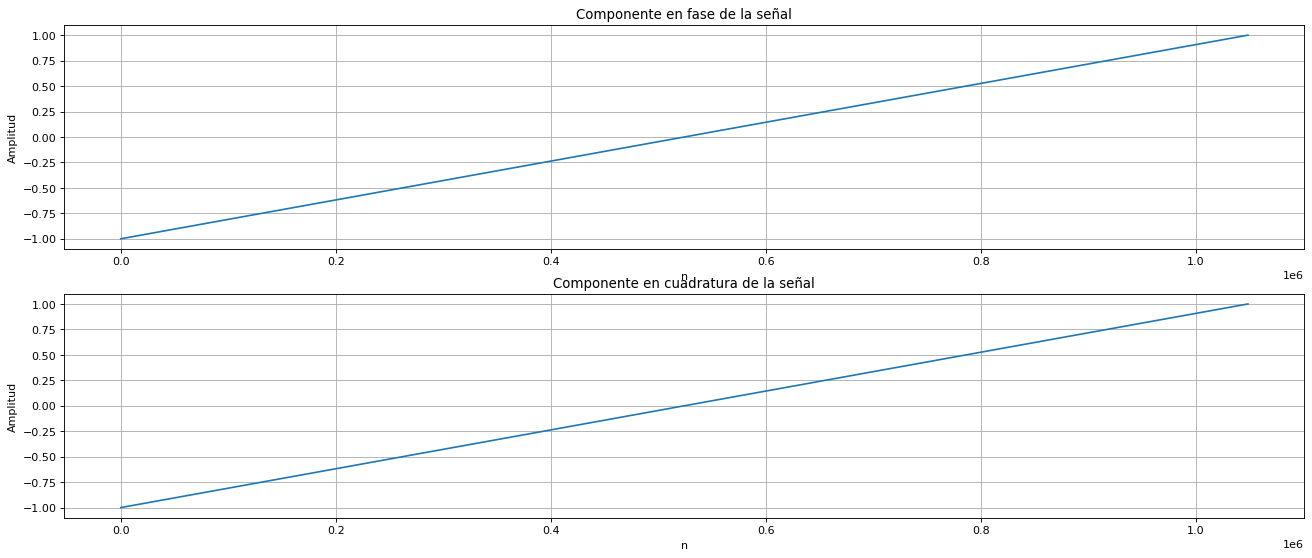

In [8]:
print('Señal transmitida por el SDR')
plotSignal(txSignal)

Señal recibida por el SDR


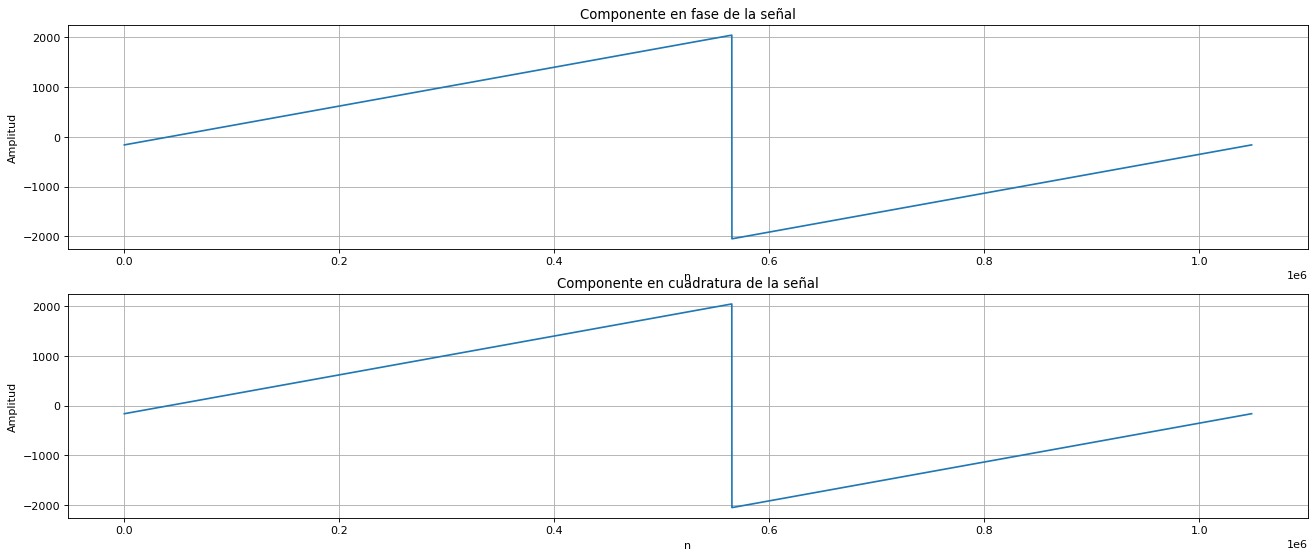

In [9]:
print('Señal recibida por el SDR')
plotSignal(samples)

In [10]:
# Since it is not possible to turn off Tx, it is configured to transmit at low power and on a different frequency than Rx.
sdr.tx_destroy_buffer()
sdr.tx_hardwaregain_chan0 = -89 
sdr.tx_lo                 = int(2400e6)
sdr.rx_lo                 = int(950e6)
sdr.tx(np.zeros(2048))

In [11]:
# Destroy radio object
del(sdr)

[![CC BY 4.0][cc-by-shield]][cc-by]

This work is licensed under a
[Creative Commons Attribution 4.0 International License][cc-by].

[![CC BY 4.0][cc-by-image]][cc-by]

[cc-by]: http://creativecommons.org/licenses/by/4.0/
[cc-by-image]: https://i.creativecommons.org/l/by/4.0/88x31.png
[cc-by-shield]: https://img.shields.io/badge/License-CC%20BY%204.0-lightgrey.svg

![logo_neon_erasmus](https://raw.githubusercontent.com/neon-iot/communication_labs/main/detection_theory/notebooks/images/BannerSupportErasmus_.png)

